### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import Settings
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *

#### Train the network

In [2]:
cluster_env = Cluster_Env(clusters=60, cluster_size=30)
centered_env = Centered_Env(food_amount=1000)
circle_env = Circle_Env(circles=4, food_amount=1000)
spiral_env = Spiral_Env(radius=0.5, food_amount=1000)

In [3]:
popsize = 20
generations = 100
name = 'hidden4'

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 2,
    n = 100,
    #food_env=cluster_env,
    #food_env=centered_env,
    #food_env=circle_env,
    food_env=spiral_env,
    scale = 4,
    wrap_around = True,
    model_type = ModelType.LocalOnly,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 3,
    noise = 0.002,
    energy_required_to_replicate = 50,
)

In [4]:
#TODO ADD settings like std of clusters..
trainer = Evo_Trainer(settings, popsize)
network = Conv(settings=settings)

2023-04-06 22:01:01,948	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-06 22:01:17] INFO     <19844> evotorch.core: Instance of `Custom_NEProblem` (id:4451810992) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-06 22:01:17] INFO     <19844> evotorch.core: Instance of `Custom_NEProblem` (id:4451810992) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-06 22:01:17] INFO     <19844> evotorch.core: Instance of `Custom_NEProblem` (id:4451810992) -- The `device` of the problem is set as cpu
[2023-04-06 22:01:17] INFO     <19844> evotorch.core: Instance of `Custom_NEProblem` (id:4451810992) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-06 22:01:17] INFO     <19844> evotorch.core: Instance of `Custom_NEProblem` (id:4451810992) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [19]:
trainer.train(generations, name)

         iter : 101
     stepsize : ReadOnlyTensor(0.0348)
    mean_eval : 109.3010025024414
pop_best_eval : 124.61000061035156
  median_eval : 110.49500274658203

         iter : 102
     stepsize : ReadOnlyTensor(0.0347)
    mean_eval : 136.9844970703125
pop_best_eval : 147.0800018310547
  median_eval : 140.6300048828125

         iter : 103
     stepsize : ReadOnlyTensor(0.0347)
    mean_eval : 110.7889404296875
pop_best_eval : 120.83416748046875
  median_eval : 112.86431884765625

         iter : 104
     stepsize : ReadOnlyTensor(0.0347)
    mean_eval : 131.21600341796875
pop_best_eval : 138.36000061035156
  median_eval : 133.77000427246094

         iter : 105
     stepsize : ReadOnlyTensor(0.0347)
    mean_eval : 107.26200866699219
pop_best_eval : 112.5199966430664
  median_eval : 109.83000183105469

         iter : 106
     stepsize : ReadOnlyTensor(0.0346)
    mean_eval : 102.7455062866211
pop_best_eval : 108.73999786376953
  median_eval : 104.93000030517578

         iter : 1

In [20]:
network = trainer.get_trained_network()

In [21]:
#trainer.logger_df.from_csv('../logger/' + name + '.csv')
#network.load_state_dict(torch.load('../models/' + name + '.pth'))

In [22]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])
#network = trainer.problem.parameterize_net(trainer.searcher.status['obj0_pop_best'])

In [23]:
#trainer.searcher.status

#### Visualize trained network

In [24]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network.batch_size = settings.batch_size
network(graph, 0)

DataBatch(x=[2200, 11], edge_index=[1, 0], device=[2], subsize=[2], velocity=[2], border_cost=[2], food_reward=[2], dead_cost=[2], visible_food=[2], food_avg_dist=[2], food_avg_degree=[2], food_search_movement=[2], batch=[2200], ptr=[3])

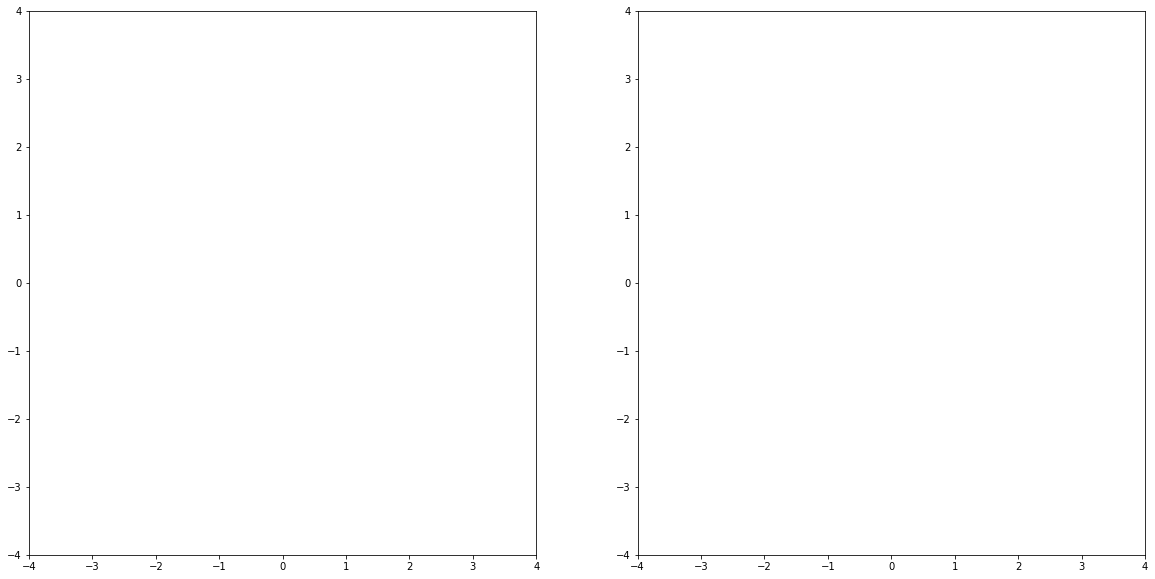

In [25]:
frames = 100 #test
#frames = 200 #visualize

#dpi = 200 #beautiful
dpi = 50 #fast

anim = visualizer.animate_organism(graph, network, food=30, frames=frames) 
visualizer.save_animation_to_gif(anim, name, fps=10, dpi=dpi)

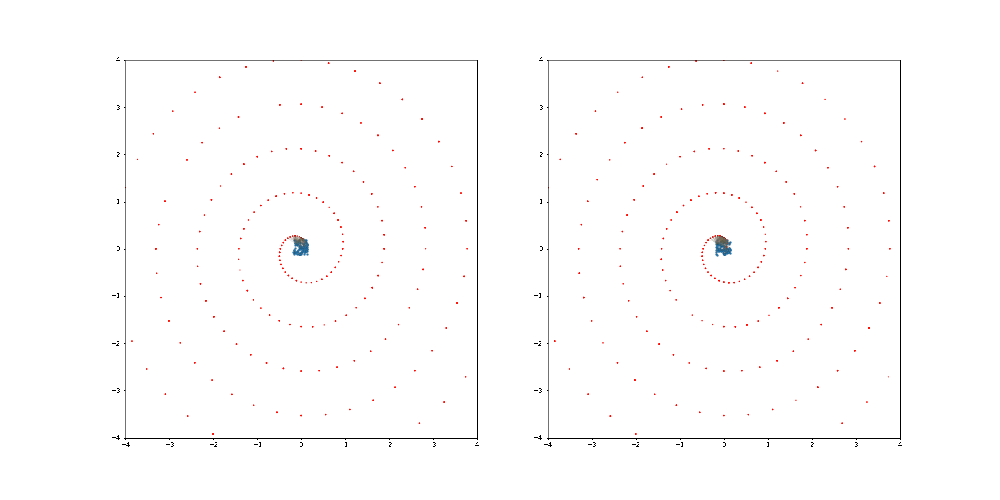

In [26]:
Image('../animation/' + name + '.gif')

In [13]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

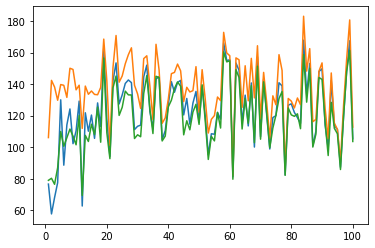

In [14]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
#plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()